In [2]:
from glob import glob
import numpy as np
import cv2
from gi.repository import Vips
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
def imshow(img):
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = np.dstack([img, img, img])
    plt.imshow(img)
    plt.show()

In [4]:
dir_path = "./tmp/"
files = sorted(glob(dir_path + '*.TIF'))
files

['./tmp/14OCT06063658-P2AS_R1C1-053950035020_01_P001.TIF',
 './tmp/14OCT06063756-P2AS_R1C1-053950035020_01_P001.TIF']

In [7]:
# imshow(np.dstack([img[:, :, 1], img[:, :, 2], img[:, :, 4]]))

In [5]:
def to_numpy_img(img):
    offset_x, offset_y, size_x, size_y = 1024*6, 1024*5, 1024, 1024
    img = img.extract_area(offset_x, offset_y, size_x, size_y)
    return np.uint8(np.fromstring(img.write_to_memory()).view(np.int16).reshape(size_y, size_x) / 8)

# def to_numpy_img_rgb(img):
#     offset_x, offset_y, size_x, size_y = 1024*0, 1024*0, 1024, 1024
#     img = img.extract_area(offset_x, offset_y, size_x, size_y)
#     return np.uint8(np.fromstring(img.write_to_memory()).view(np.int16).reshape(img.height, img.width, 8) / 8)[:, :, 
#                                 [0, 1, 2]]

img0 = Vips.Image.new_from_file(files[0])
img1 = Vips.Image.new_from_file(files[1])

# img0, img1 = to_numpy_img_(img0), to_numpy_img(img1)
# w, h
# w, h = img0.width, img0.height
# w, h
img0, img1 = to_numpy_img(img0), to_numpy_img(img1)
w, h = img0.shape[:2][::-1]
w, h

(1024, 1024)

In [32]:
def read_vips(filename):
    return Vips.Image.new_from_file(filename)

def extract_gray(image, offset_x, offset_y, size_x=1024, size_y=1024):
    subimage = image.extract_area(offset_x, offset_y, size_x, size_y)
    mat = np.fromstring(subimage.write_to_memory()).view(np.int16)
    return np.uint8(mat.reshape(size_y, size_x) / 8)

def extract_rgb(image, offset_x, offset_y, size_x=256, size_y=256):
    subimage = image.extract_area(offset_x, offset_y, size_x, size_y)
    channels = [4, 2, 1]
    mat = np.fromstring(subimage.write_to_memory()).view(np.int16)
    return np.uint8(mat.reshape(size_y, size_x, 8) / 8)[:, :, channels]
    

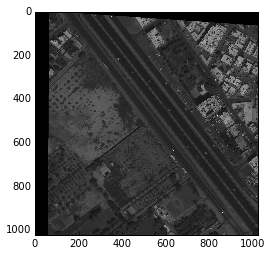

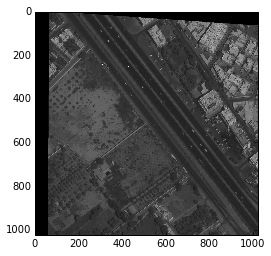

In [33]:

img0 = read_vips(files[0])
img0 = extract_gray(img0, 0, 0)
imshow(img0)

img1 = read_vips(files[1])
img1 = extract_gray(img1, 0, 0)
imshow(img1)

In [34]:
cv2.imwrite(dir_path + "/0.png", img0)
cv2.imwrite(dir_path + "/1.png", img1)

True

In [35]:
def nabla(flow):
    ddxx = flow[:-1, 1:, 0] - flow[:-1, :-1, 0]
    ddxy = flow[1:, :-1, 0] - flow[:-1, :-1, 0]
    ddyx = flow[:-1, 1:, 1] - flow[:-1, :-1, 1]
    ddyy = flow[1:, :-1, 1] - flow[:-1, :-1, 1]

    return np.mean(np.dstack([ddxx, ddxy, ddyx, ddyy]), axis=-1)

In [36]:
levels=1
winsize=2
flow = cv2.calcOpticalFlowFarneback(img1, img0, None, 0.5, levels, winsize, 3, 5, 1.1, 0)
# flow -= np.median(flow.reshape(-1, 2), axis=0)
flow_nabla = nabla(flow)

flow = ((flow[:, :, 0]**2 + flow[:, :, 1]**2)**0.5)
flow = np.uint8(flow*255/flow.max())
cv2.imwrite(dir_path + "/flow.png", flow)

True

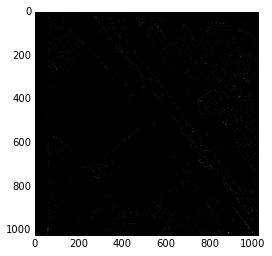

In [37]:
flow_nabla_normalized = np.uint8(np.abs(flow_nabla)*255/flow_nabla.max())
cv2.imwrite(dir_path + "/nabla.png", flow_nabla_normalized)
imshow(flow_nabla_normalized)

In [38]:
def norm(ps):
    ps = ps.reshape(-1, 2)
    return np.sum(ps ** 2, axis=-1) ** 0.5

In [39]:
def checked_flow(gray_img0, gray_img1, p0, max_err=1.0, win_size=15, max_level=3):
    lk_params = dict(winSize=(win_size, win_size),
                     maxLevel=max_level,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 20, 0.1))
    h, w = gray_img0.shape[:2]
    p0 = p0 * w
    p_idx = np.arange(len(p0))

    p1, _, _ = cv2.calcOpticalFlowPyrLK(gray_img0, gray_img1, p0, None, **lk_params)
    p0r, _, _ = cv2.calcOpticalFlowPyrLK(gray_img1, gray_img0, p1, None, **lk_params)
    err = norm(p0-p0r).ravel()
    good = err < max_err
    p1, p_idx, err = p1.reshape(-1, 2)[good], p_idx[good], err[good]
    return p1/w, p_idx, err

In [40]:
def to_int_tuple(p, w):
    return (int(p[0]*w), int(p[1]*w))

In [41]:
import sys
xfeatures2d = sys.modules['cv2.xfeatures2d']
SURF = xfeatures2d.SURF_create

In [42]:
detector = SURF(hessianThreshold=200, nOctaves=1, nOctaveLayers=1, extended=False)
kps0, desc0 = detector.detectAndCompute(img0, None)
# kps1, desc1 = detector.detectAndCompute(img1, None)

# matcher = cv2.BFMatcher(cv2.NORM_L2)

# cv_matches = matcher.knnMatch(desc0, trainDescriptors=desc1, k=2)
# cv_matches = [m[0] for m in cv_matches
#               if len(m) == 2 and m[0].distance < m[1].distance * 0.75]
# matches = np.array([[m.queryIdx, m.trainIdx] for m in cv_matches])

# print(len(matches))

kps0 = np.float32([kp.pt for kp in kps0]) / w
# kps1 = np.float32([kp.pt for kp in kps1]) / w

# gft_detector = cv2.GFTTDetector_create(maxCorners=w*40, qualityLevel=0.02, minDistance=9, blockSize=5)
# kps0 = gft_detector.detect(img0) # cv2.goodFeaturesToTrack(img0, w*10, 0.01, 10)
# kps0 = np.float32([p[0] for p in kps0]) / w
# kps0 = np.float32([p.pt for p in kps0]) / w

kps1, kps0_idx, err = checked_flow(img0, img1, kps0, win_size=50)

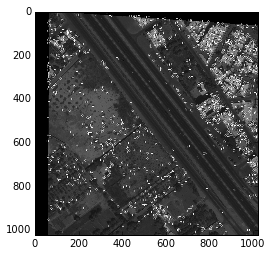

In [43]:
img = img0.copy()
for kp0 in kps0:
    cv2.circle(img, to_int_tuple(kp0, w), 5, (255, 0, 0))
imshow(img)

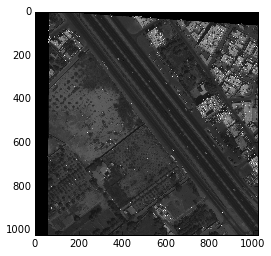

True

In [44]:
img = img0.copy()
# for kp0_id, kp1_id in matches:
#     kp1 = kps1[kp1_id]
for kp1, kp0_id in zip(kps1, kps0_idx):
    kp0 = kps0[kp0_id]
    p0, p1 = to_int_tuple(kp0, w), to_int_tuple(kp1, w)
    cv2.line(img, p0, p1, (255, 0, 0))
imshow(img)
cv2.imwrite(dir_path + 'vects.png', img)

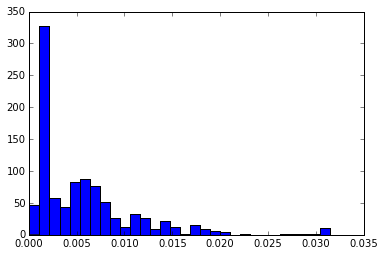

In [45]:
dps = norm(kps1 - kps0[kps0_idx])
plt.hist(dps, bins=30);

In [50]:
kps1.shape

(968, 2)

In [51]:
F, F_mask = cv2.findFundamentalMat(kps0[kps0_idx]*w, kps1*w, method=cv2.FM_RANSAC)
F_mask = F_mask == 1
F_mask = F_mask.reshape(-1)
F_mask.sum() / len(kps1)

0.9473140495867769

In [52]:
def homogenize(a, w=1.0):
    o = np.zeros((len(a), 1), a.dtype)
    o[:] = w
    return np.hstack([a, o])

In [53]:
def homo_translate(matrix, points):
    points = np.atleast_2d(points)
    if points.shape[-1] < matrix.shape[1]:
        points = homogenize(points)
    p = np.dot(points, matrix.T)
    return p[:, :-1] / p[:, -1, np.newaxis]

In [54]:
kps0_masked = kps0[kps0_idx][F_mask].reshape(-1, 2)
kps1_masked = kps1[F_mask].reshape(-1, 2)

In [55]:
kps1_masked-kps0_masked

array([[ 0.00013649, -0.00769019],
       [ 0.00431114, -0.01704562],
       [ 0.00368798, -0.0108837 ],
       ..., 
       [ 0.00354093, -0.00846231],
       [ 0.00157216,  0.00081161],
       [ 0.00164399,  0.00077814]], dtype=float32)

In [56]:
_, H1, H2 = cv2.stereoRectifyUncalibrated(kps0_masked * w, kps1_masked * w, F, (w, h))

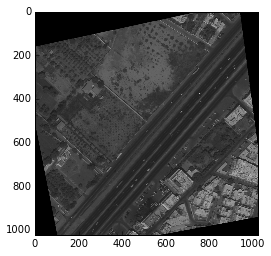

In [57]:
rect1 = cv2.warpPerspective(img1, H2, (w, h))
imshow(rect1)

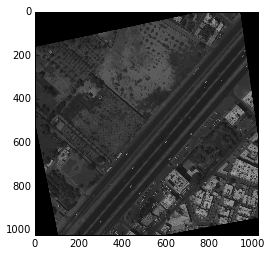

In [58]:
rect0 = cv2.warpPerspective(img0, H1, (w, h))
imshow(rect0)

In [59]:
for p in np.array([[0.0, 0.0, 1.0], [w, 0.0, 1.0], [0.0, w, 1.0], [w, w, 1.0]]):
    tmp = H1.dot(p)
    print(tmp[:2] / tmp[2])

[ 918.38946265  -97.33408721]
[ 1138.91598314   922.57574075]
[ -79.59431157  122.0305027 ]
[  122.61159322  1110.86987496]


In [60]:
cv2.imwrite(dir_path + "rect0.png", rect0)
cv2.imwrite(dir_path + "rect1.png", rect1)

True

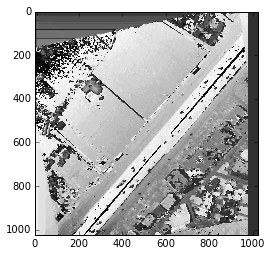

True

In [61]:
SADWindowSize=3
P1, P2 = 2*SADWindowSize**2, 32*SADWindowSize**2
sgbm = cv2.StereoSGBM_create(-50, 128, SADWindowSize, P1, P2, speckleWindowSize=50, speckleRange=2)
disp = sgbm.compute(rect0, rect1)
imshow(disp)
cv2.imwrite(dir_path + "disp.png", disp)